In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from harmony import harmonize

import sys
sys.path.append("../resources/")
import sct

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata = sc.read_h5ad('../data/48h_all.h5ad')
adata

AnnData object with n_obs × n_vars = 1214 × 15149 
    obs: 'genotype', 'n_counts', 'n_genes', 'stage', 'PN_type', 'conc'
    var: 'highly_variable'
    obsm: 'X_tsne'

In [4]:
df_libs = pd.read_csv("../data/libs.csv", sep="\t", header=0, index_col=0) # sample info

In [5]:
genes_GH146_ICIM = []
with open("../data/ICIM_genes/24h_ICIM_561.txt") as f:
    for line in f:
        genes_GH146_ICIM.append(line.rstrip())

print("Total ICIM genes= ", len(genes_GH146_ICIM))

Total ICIM genes=  561


check data

In [6]:
adata.obs['genotype'].value_counts()

GH146-GFP    913
kn-GFP       209
Mz19-GFP      92
Name: genotype, dtype: int64

In [7]:
adata_kn = adata[adata.obs['genotype'] == 'kn-GFP']

In [8]:
adata.var['highly_variable'] = adata.var_names.isin(genes_GH146_ICIM)

In [9]:
adata.var['highly_variable'].value_counts()

False    14594
True       555
Name: highly_variable, dtype: int64

# subset data

In [10]:
# get knot+ cells from adult pan-PN cells
adata_kn_1 = adata[(adata.obs['genotype'] == 'GH146-GFP') & (adata.to_df()['kn'] > 4)]
adata_kn_1

View of AnnData object with n_obs × n_vars = 169 × 15149 
    obs: 'genotype', 'n_counts', 'n_genes', 'stage', 'PN_type', 'conc'
    var: 'highly_variable'
    obsm: 'X_tsne'

In [11]:
# get adult cells from knot-GAL4
adata_kn_2 = adata[(adata.obs['genotype'] == 'kn-GFP')]
adata_kn_2

View of AnnData object with n_obs × n_vars = 209 × 15149 
    obs: 'genotype', 'n_counts', 'n_genes', 'stage', 'PN_type', 'conc'
    var: 'highly_variable'
    obsm: 'X_tsne'

In [12]:
adata_conc = adata_kn_1.concatenate(adata_kn_2, index_unique=None)
adata_conc

AnnData object with n_obs × n_vars = 378 × 15149 
    obs: 'PN_type', 'batch', 'conc', 'genotype', 'n_counts', 'n_genes', 'stage'
    var: 'highly_variable'
    obsm: 'X_tsne'

# plot knot

In [13]:
X = adata_conc.to_df().T

In [15]:
myTSNE = sct.TSNE(X.loc[genes_GH146_ICIM], X, df_libs)
myTSNE.calc_TSNE(perplexity=13, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


[t-SNE] Computed conditional probabilities for sample 378 / 378
[t-SNE] Mean sigma: 0.142946
[t-SNE] Iteration 50: error = 14.8740874, gradient norm = 0.1767917 (50 iterations in 0.376s)
[t-SNE] Iteration 100: error = 15.2640928, gradient norm = 0.1736597 (50 iterations in 0.374s)
[t-SNE] Iteration 150: error = 15.4596524, gradient norm = 0.1802119 (50 iterations in 0.346s)
[t-SNE] Iteration 200: error = 15.5857128, gradient norm = 0.1547961 (50 iterations in 0.329s)
[t-SNE] Iteration 250: error = 14.6093036, gradient norm = 0.1839941 (50 iterations in 0.334s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 14.609304
[t-SNE] Iteration 300: error = 0.8342195, gradient norm = 0.0030395 (50 iterations in 0.335s)
[t-SNE] Iteration 350: error = 0.7949687, gradient norm = 0.0007519 (50 iterations in 0.330s)
[t-SNE] Iteration 400: error = 0.7808593, gradient norm = 0.0003608 (50 iterations in 0.340s)
[t-SNE] Iteration 450: error = 0.7736784, gradient norm = 0.0002022 (50 i

In [16]:
adata_conc.obsm['X_tsne'] = myTSNE.X_tsne

In [17]:
adata_conc.uns['genotype_colors'] = ['#b9bbbd','#1f77b4']

... storing 'genotype' as categorical


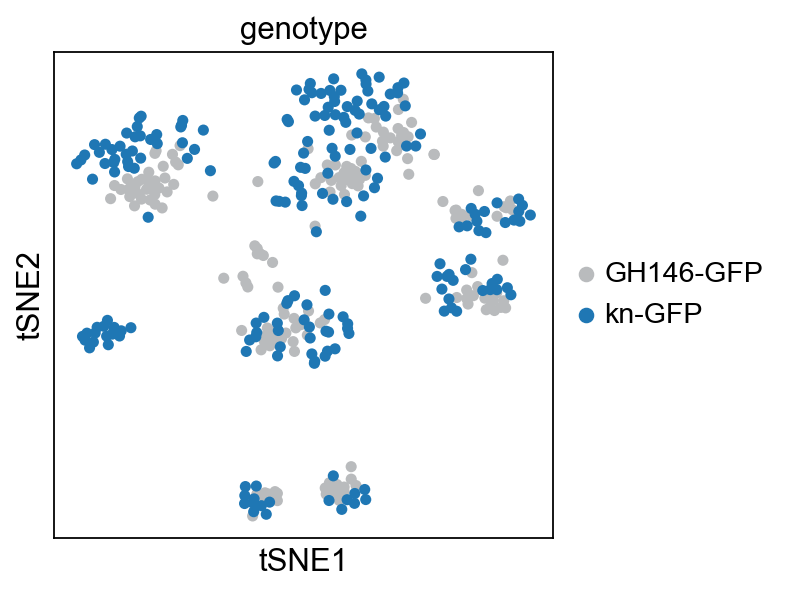

In [18]:
sc.pl.tsne(adata_conc, color='genotype', size=(100,100))

In [19]:
adata_conc.obs['PN_type'].value_counts()

D                        73
DM4 or VM5v (CG8861-)    58
VA1v                     57
DM4 or VM5v (CG8861+)    38
vPN                      37
DM6                      37
VM2                      30
nan                      29
vPN_DA1                  19
Name: PN_type, dtype: int64

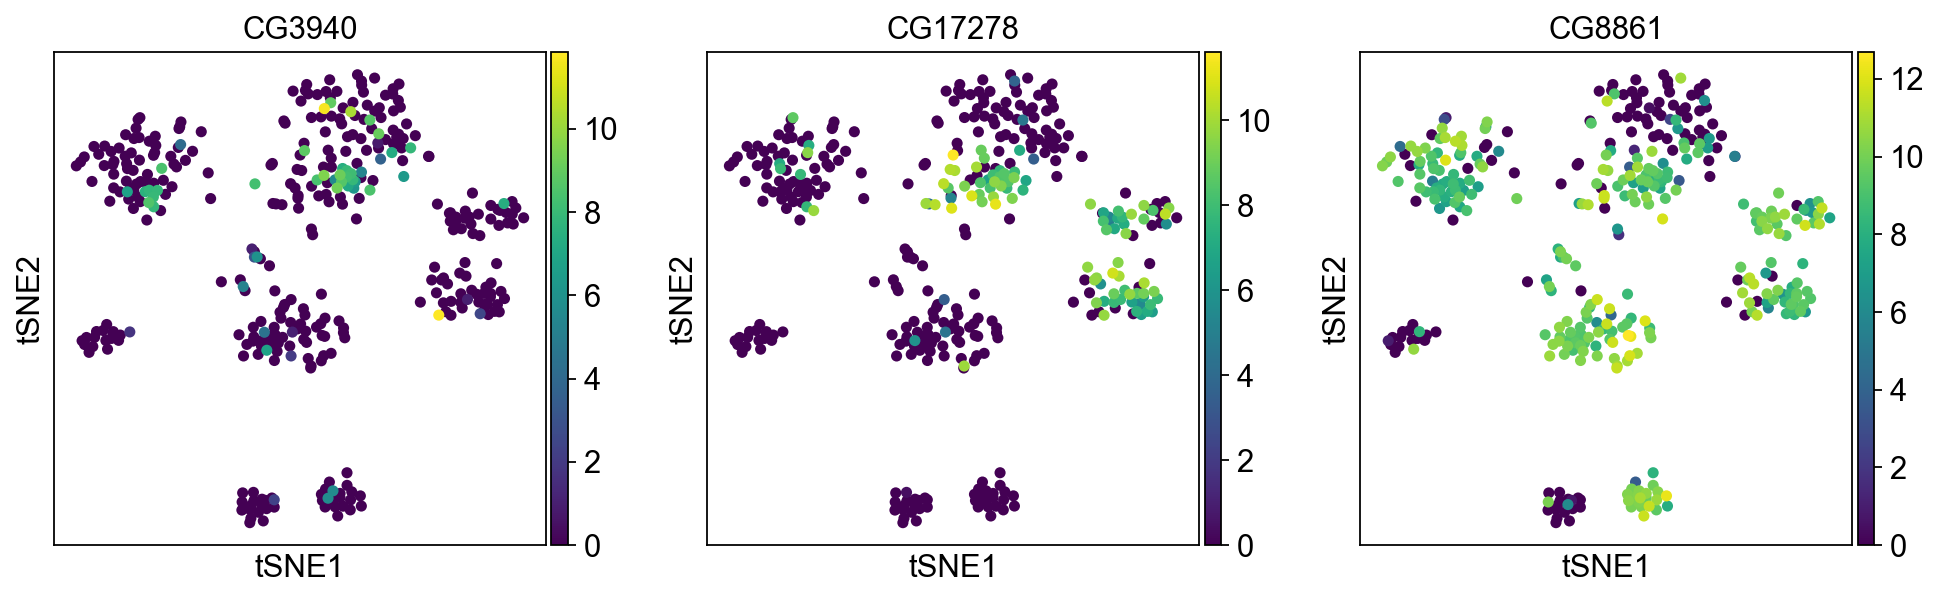

In [20]:
sc.pl.tsne(adata_conc, color=['CG3940','CG17278','CG8861'], size=(100,100))

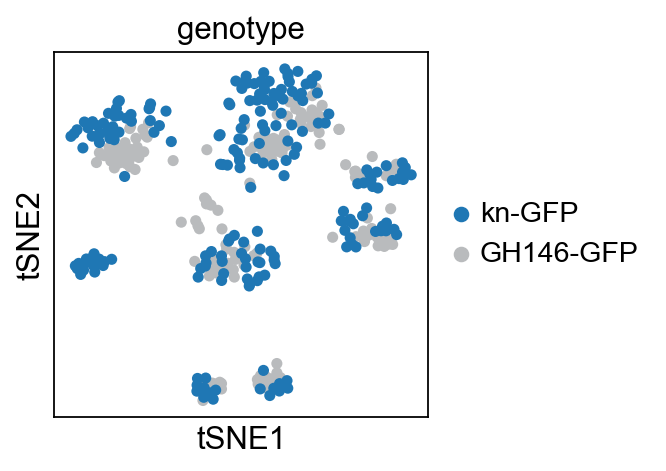

In [21]:
sc.set_figure_params(figsize=(3,3), dpi_save=600)
sc.pl.tsne(adata_conc, color='genotype', size=(100,100), groups=['kn-GFP','GH146-GFP'],
        save='_48h_kn_stage.pdf')

In [22]:
adata_conc.obs['PN_type_1'] = 'nan'
PN_type_1 = adata[(adata.obs['genotype'] == 'kn-GFP')].obs['PN_type']
PN_type_1 = PN_type_1.replace('NaN','nan')
PN_type_1 = PN_type_1.replace('vPN_DA1','vPN')
PN_type_1 = PN_type_1.cat.remove_unused_categories()
PN_type_1.value_counts()

D                        40
DM4 or VM5v (CG8861-)    36
vPN                      35
VA1v                     32
DM4 or VM5v (CG8861+)    21
VM2                      18
DM6                      18
nan                       9
Name: PN_type, dtype: int64

In [23]:
adata_conc.obs['PN_type_1'] = PN_type_1
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].fillna('nan')

In [24]:
adata_conc.obs['PN_type_1'].value_counts()

nan                      178
D                         40
DM4 or VM5v (CG8861-)     36
vPN                       35
VA1v                      32
DM4 or VM5v (CG8861+)     21
VM2                       18
DM6                       18
Name: PN_type_1, dtype: int64

In [25]:
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].cat.add_categories(['VM7 or VM5v #1','VM7 or VM5v #2'])
adata_conc.obs['PN_type_1'][np.in1d(adata_conc.obs['PN_type_1'], ['DM4 or VM5v (CG8861+)'])] = 'VM7 or VM5v #1'
adata_conc.obs['PN_type_1'][np.in1d(adata_conc.obs['PN_type_1'], ['DM4 or VM5v (CG8861-)'])] = 'VM7 or VM5v #2'
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].cat.remove_categories(['DM4 or VM5v (CG8861-)','DM4 or VM5v (CG8861+)'])

In [26]:
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].cat.reorder_categories(['D', 'DM6', 'VA1v', 'VM2', 'vPN', 'VM7 or VM5v #1','VM7 or VM5v #2', 'nan'])

In [40]:
adata_conc.uns['PN_type_1_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#e377c2', '#b9bbbd']

In [36]:
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].replace('nan','not decoded')
new_order = ['D', 'DM6', 'VA1v', 'VM2', 'VM7 or VM5v #1', 'VM7 or VM5v #2','vPN','not decoded']
adata_conc.obs['PN_type_1'] = adata_conc.obs['PN_type_1'].cat.reorder_categories(new_order)

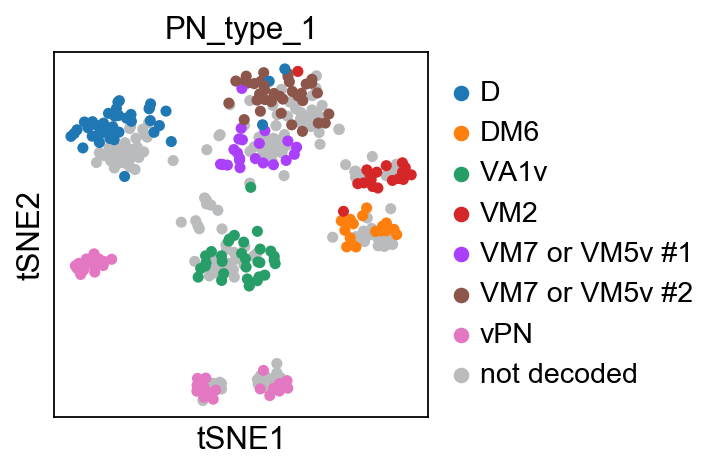

In [37]:
sc.pl.tsne(adata_conc, color='PN_type_1', size=(100,100), save='_PN_type.pdf')

# Mz19 match

In [101]:
adata.obs['genotype'].value_counts()

GH146-GFP    913
kn-GFP       209
Mz19-GFP      92
Name: genotype, dtype: int64

In [102]:
adata_select = adata[adata.obs['genotype'] != 'kn-GFP']

In [103]:
sc.pp.pca(adata_select, svd_solver='arpack', use_highly_variable=True, random_state=1)
adata_select.obsm['X_pca'] = harmonize(adata_select.obsm['X_pca'], adata_select.obs, batch_key=['genotype'])
sc.tl.tsne(adata_select, n_pcs=50, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)


In [104]:
sc.tl.tsne(adata_select, n_pcs=50, perplexity=10, learning_rate=250, 
           early_exaggeration=4.0, random_state=1)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)


In [105]:
adata_select.uns['genotype_colors'] = ['#aba6a6','#279e68']

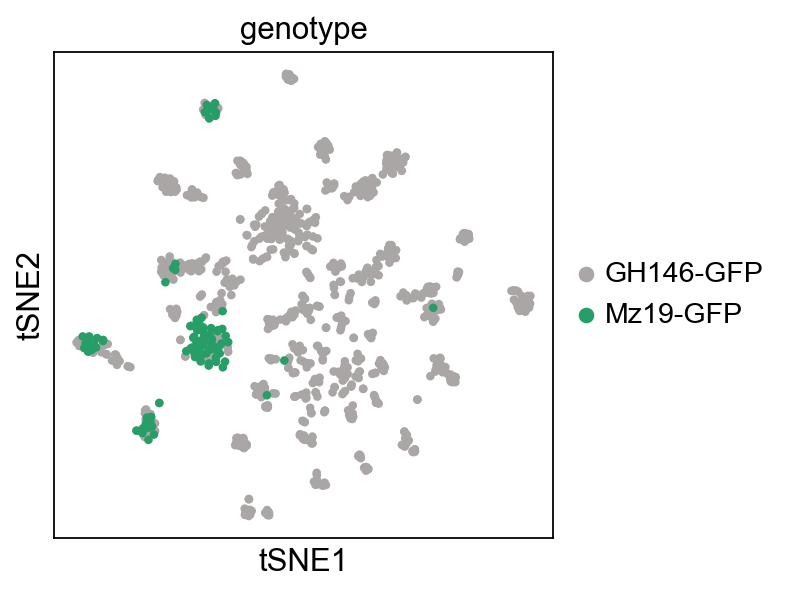

In [106]:
sc.set_figure_params(figsize=(4,4), dpi_save=600)
sc.pl.tsne(adata_select, color='genotype', size=(60,60), save='_genotype.pdf')

In [107]:
adata_mz19 = adata[adata.obs['genotype'] == 'Mz19-GFP']
adata_mz19

View of AnnData object with n_obs × n_vars = 92 × 15149 
    obs: 'genotype', 'n_counts', 'n_genes', 'stage', 'PN_type', 'conc'
    var: 'highly_variable'
    obsm: 'X_tsne'

In [108]:
adata_select.obs['PN_type_1'] = adata_mz19.obs['PN_type']
adata_select.obs['PN_type_1'] = adata_select.obs['PN_type_1'].replace('nan','not decoded')
adata_select.obs['PN_type_1'] = adata_select.obs['PN_type_1'].replace('DA1','not decoded')
adata_select.obs['PN_type_1'] = adata_select.obs['PN_type_1'].astype('category')

In [109]:
adata_select.obs['PN_type_1'].value_counts()

DA1_fru+       50
VA1d           14
DC3            14
DA1_fru-        8
not decoded     6
Name: PN_type_1, dtype: int64

In [110]:
adata_select.uns['PN_type_1_colors'] = ['#e41a1c', '#4daf4a', '#ff7f00', '#a65628', '#aba6a6']

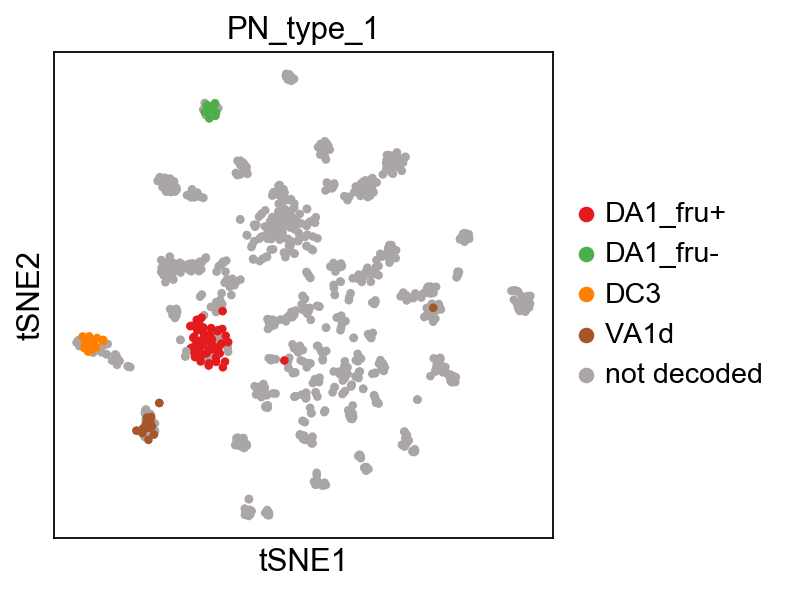

In [111]:
sc.pl.tsne(adata_select, color='PN_type_1', size=(60,60), save='_PN_type.pdf')

In [163]:
sc.pp.neighbors(adata_select, n_pcs=50, random_state=1)
sc.tl.leiden(adata_select, resolution=3)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 38 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


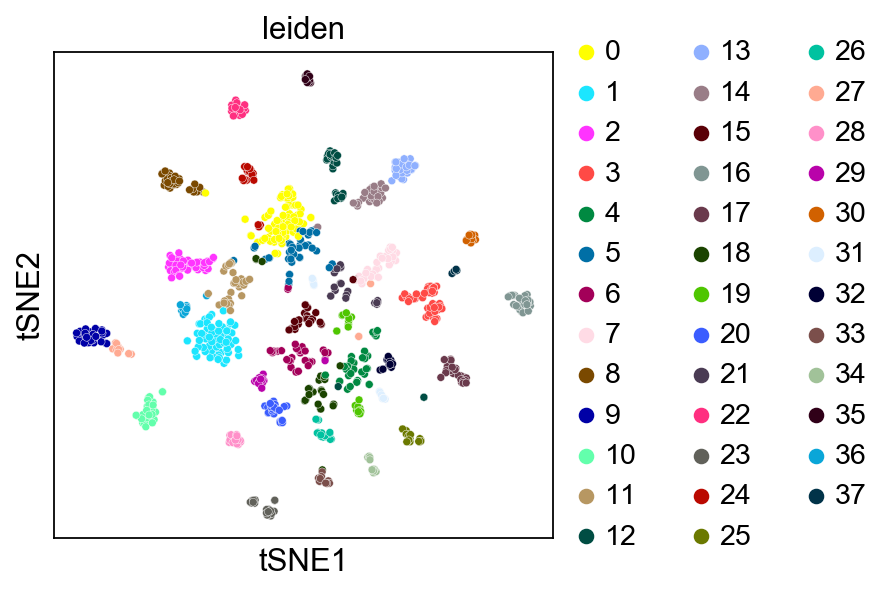

In [164]:
sc.pl.tsne(adata_select, color='leiden', size=(50,50), edgecolor="2", linewidths=0.2, save='_leiden3.pdf')

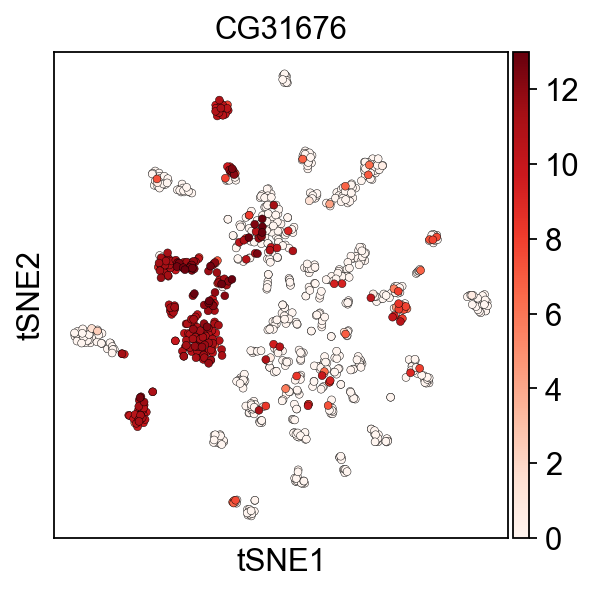

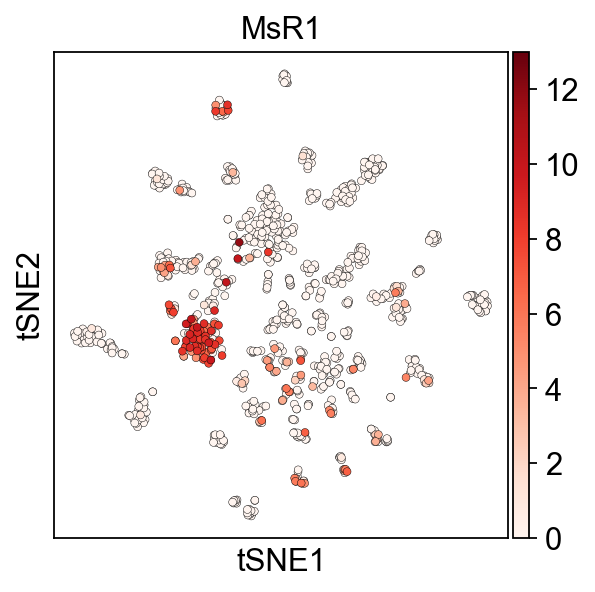

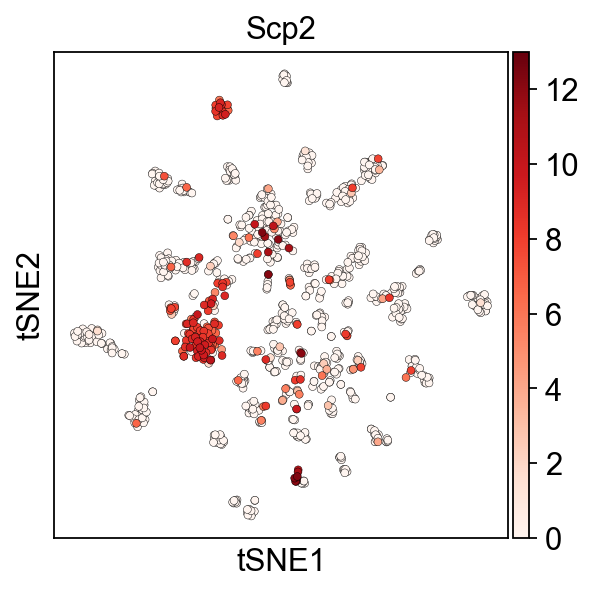

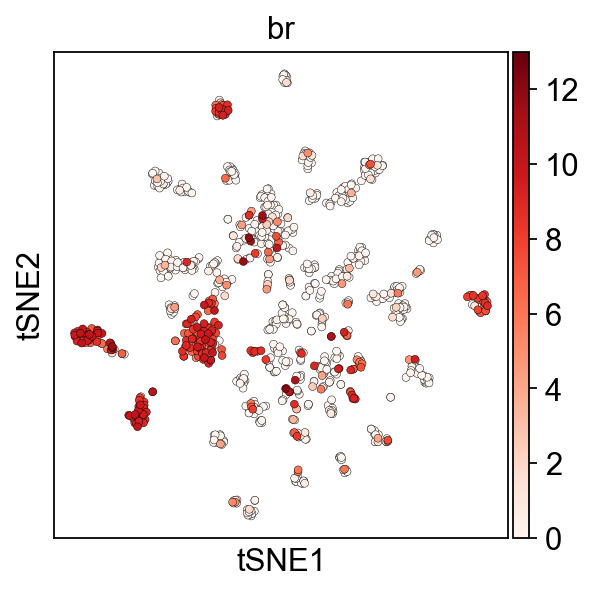

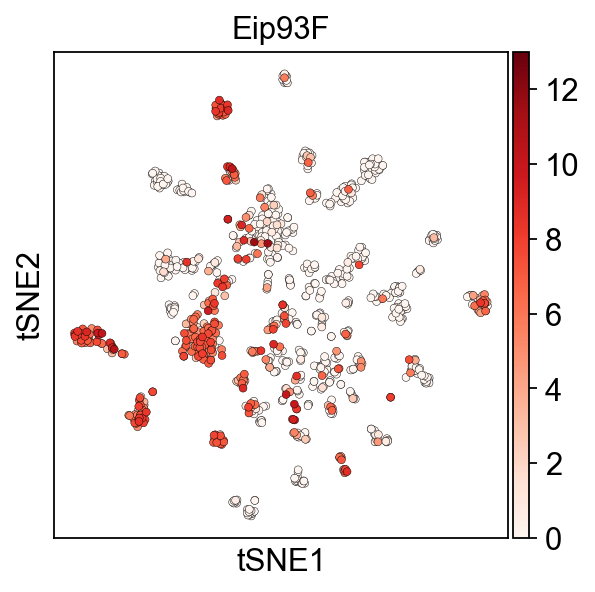

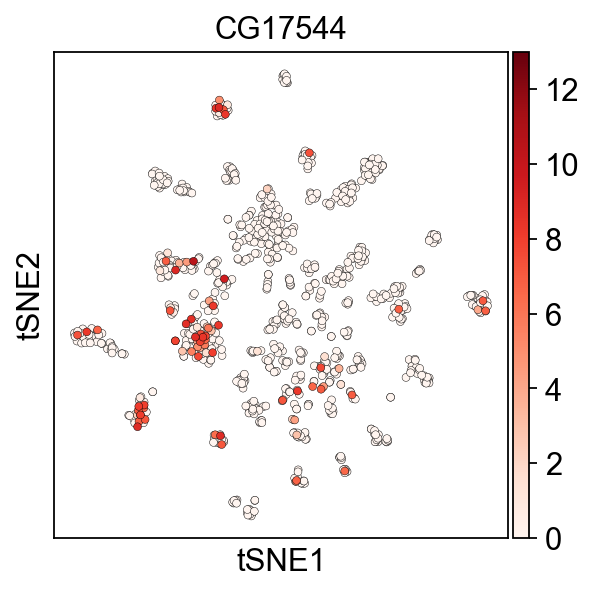

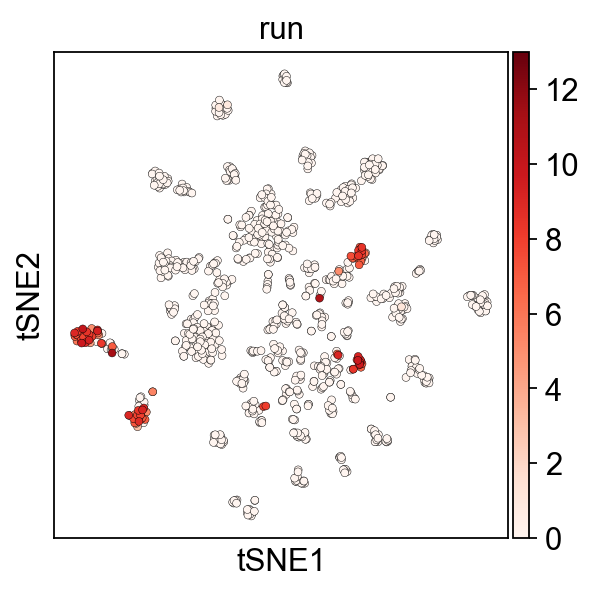

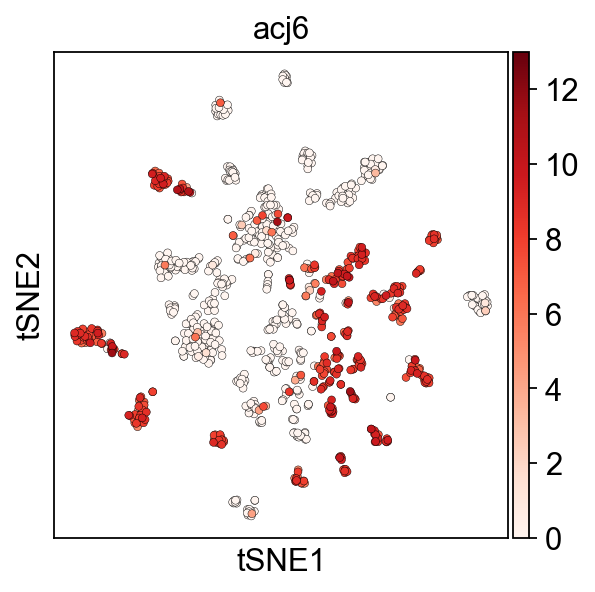

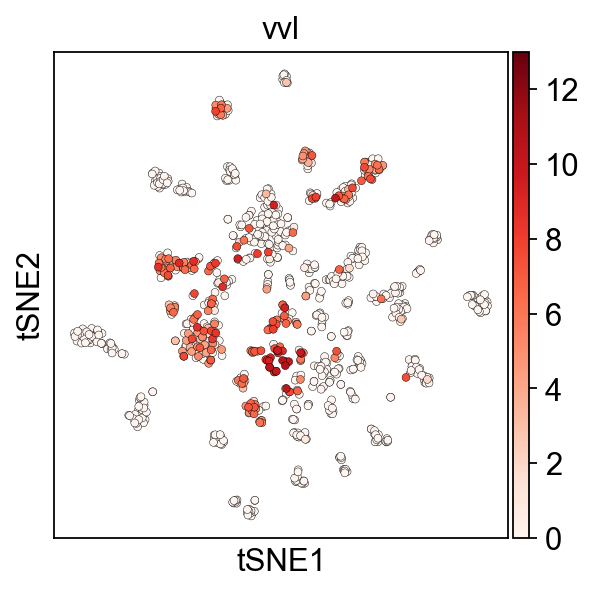

In [174]:
myGenes =['CG31676','MsR1','Scp2','br','Eip93F','CG17544','run','acj6', 'vvl']

for gene in myGenes:
    sc.pl.tsne(adata_select, color=gene, size=(50,50), edgecolor="k", linewidths=0.2, vmax=13,
               color_map="Reds", save= '_'+gene+'.pdf')

# plot decoded PN at 48h using sequenced cells

In [11]:
adata_all = adata[(adata.obs['genotype'] == 'GH146-GFP')]

In [12]:
adata_all.obs['PN_type'].value_counts()

nan                      649
D                         38
VA1v                      32
DA1_fru+                  31
DC3                       26
DM6                       25
DM4 or VM5v (CG8861-)     24
VA1d                      21
DM4 or VM5v (CG8861+)     17
DA1_fru-                  15
vPN                       13
VM2                       13
vPN_DA1                    9
Name: PN_type, dtype: int64

In [13]:
adata_all

View of AnnData object with n_obs × n_vars = 913 × 15149 
    obs: 'genotype', 'n_counts', 'n_genes', 'stage', 'PN_type', 'conc'
    var: 'highly_variable'
    obsm: 'X_tsne'

In [14]:
X = adata_all.to_df().T
myTSNE = sct.TSNE(X.loc[genes_GH146_ICIM], X, df_libs)
myTSNE.calc_TSNE(perplexity=12, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


[t-SNE] Computed conditional probabilities for sample 913 / 913
[t-SNE] Mean sigma: 0.141366
[t-SNE] Iteration 50: error = 15.9373360, gradient norm = 0.0697831 (50 iterations in 1.372s)
[t-SNE] Iteration 100: error = 14.4337898, gradient norm = 0.0342550 (50 iterations in 1.444s)
[t-SNE] Iteration 150: error = 13.9765090, gradient norm = 0.0441849 (50 iterations in 1.473s)
[t-SNE] Iteration 200: error = 13.7217394, gradient norm = 0.0292186 (50 iterations in 1.431s)
[t-SNE] Iteration 250: error = 13.5781587, gradient norm = 0.0194915 (50 iterations in 1.410s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 13.578159
[t-SNE] Iteration 300: error = 0.9786539, gradient norm = 0.0014800 (50 iterations in 1.479s)
[t-SNE] Iteration 350: error = 0.8521261, gradient norm = 0.0006224 (50 iterations in 1.449s)
[t-SNE] Iteration 400: error = 0.8061446, gradient norm = 0.0004330 (50 iterations in 1.445s)
[t-SNE] Iteration 450: error = 0.7824444, gradient norm = 0.0003098 (50 i

In [15]:
adata_all.obsm['X_tsne'] = myTSNE.X_tsne

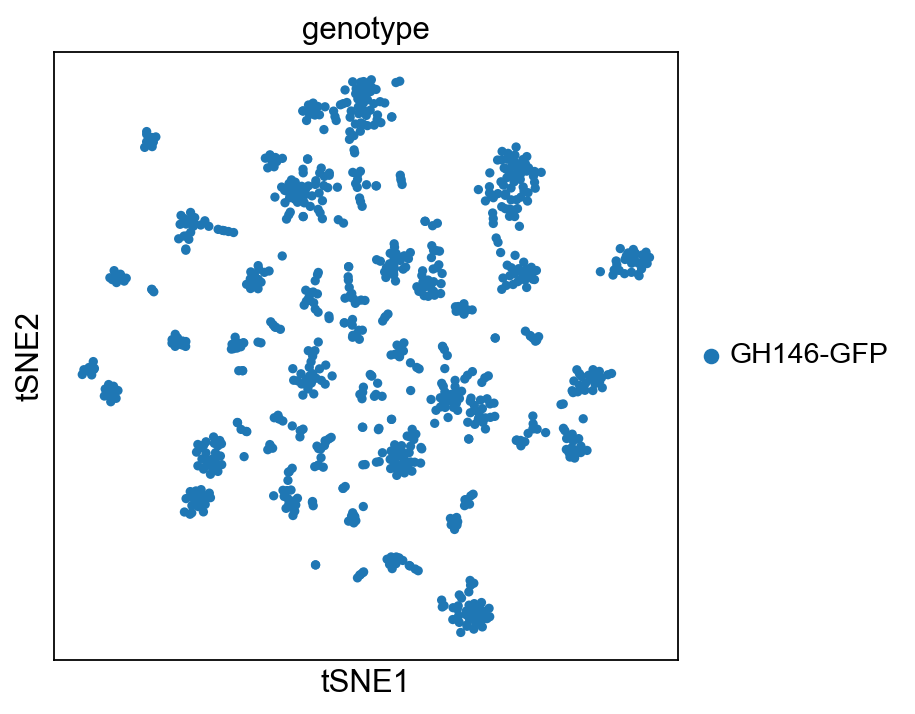

In [191]:
sc.set_figure_params(figsize=(5,5))
sc.pl.tsne(adata_all, color='genotype', size=(70,70), save='_genotype.pdf')

In [187]:
adata_all.uns['stage_colors'] = ['#3fa3e8']

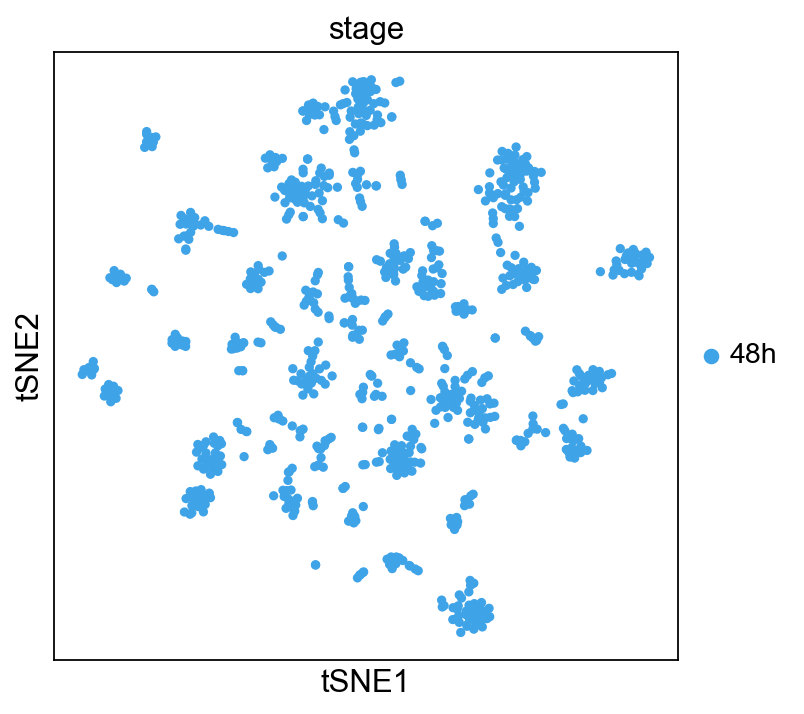

In [188]:
# sc.set_figure_params(figsize=(5,5))
sc.pl.tsne(adata_all, color='stage', size=(70,70), save='_stage.pdf')

In [193]:
adata_all.uns['PN_type_colors'][-3] = '#b9bbbd'

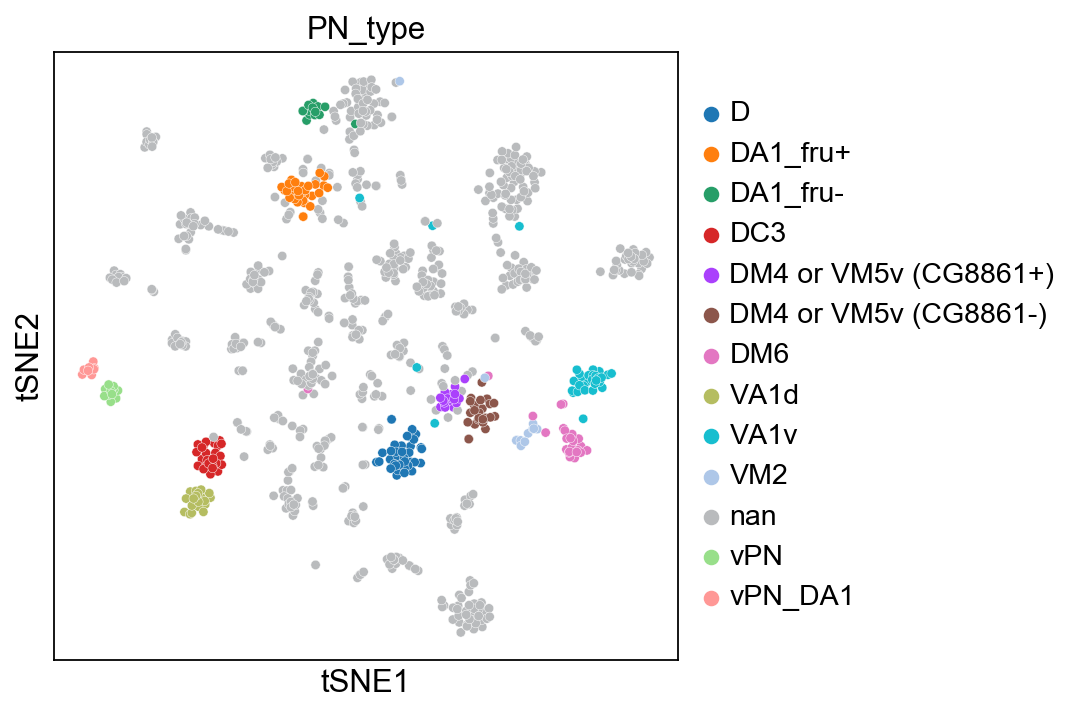

In [194]:
sc.pl.tsne(adata_all, color='PN_type', size=(70,70),
           edgecolor="w", linewidths=0.2, save='_PN_type.pdf')

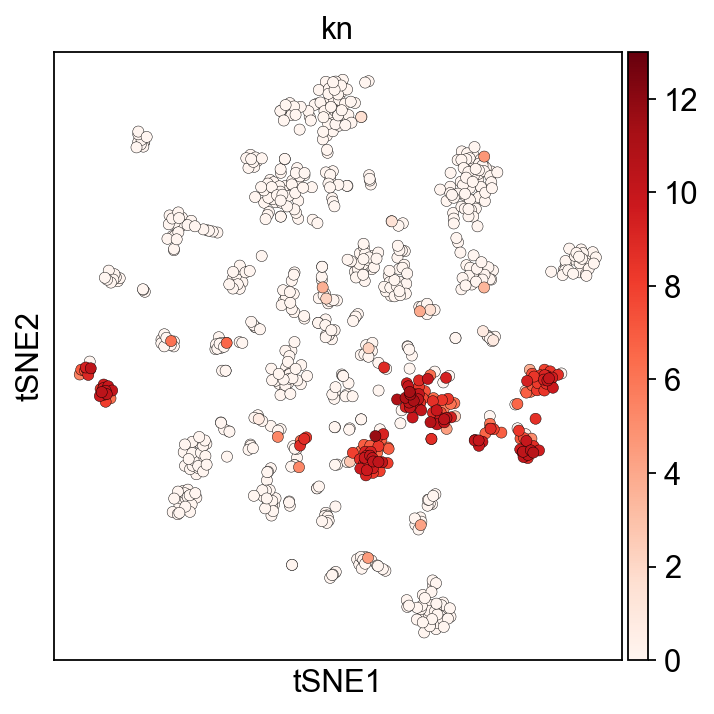

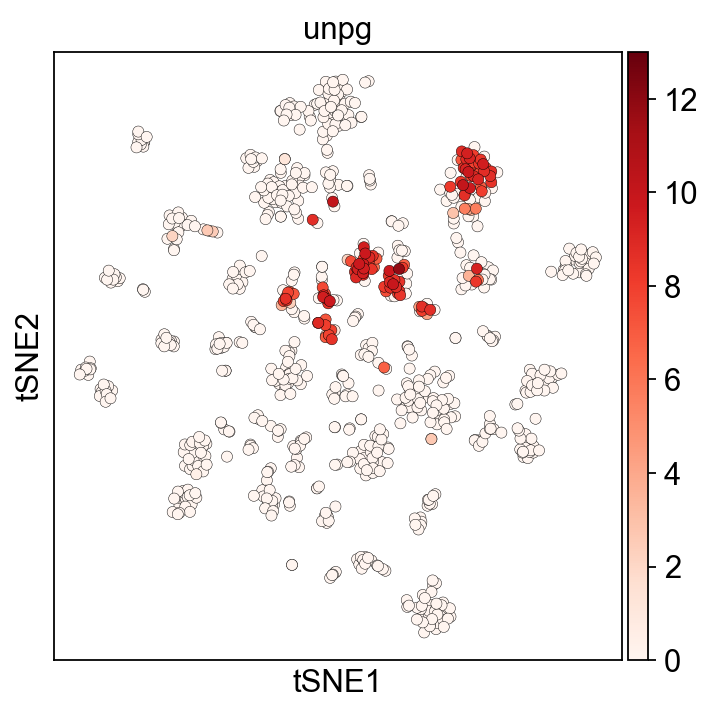

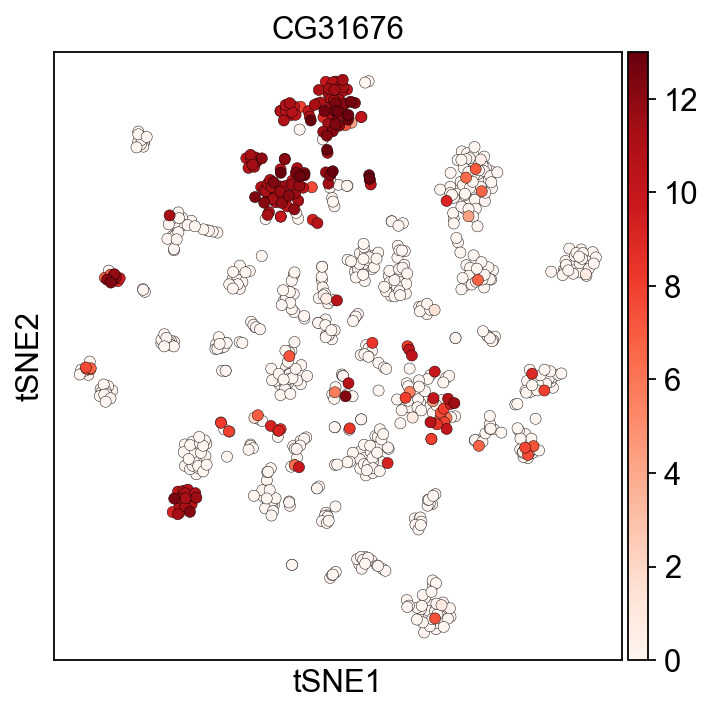

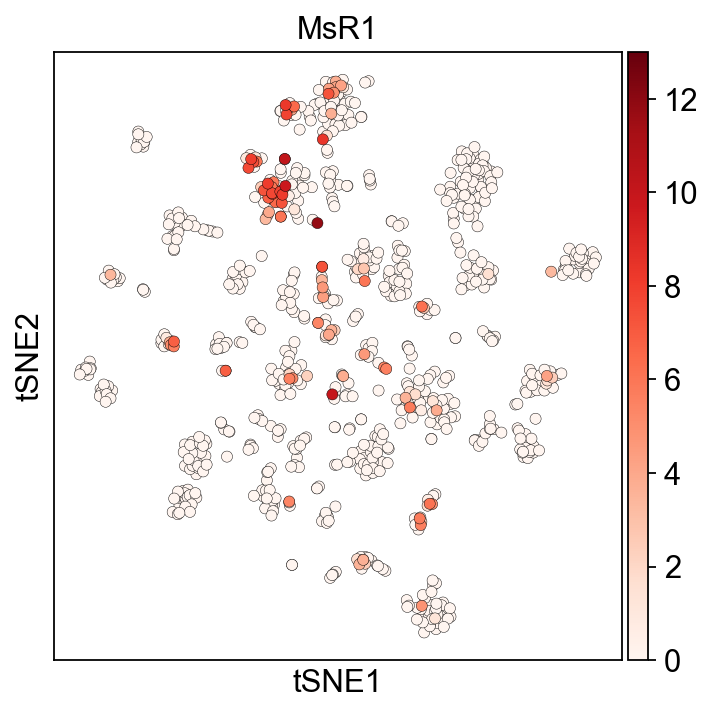

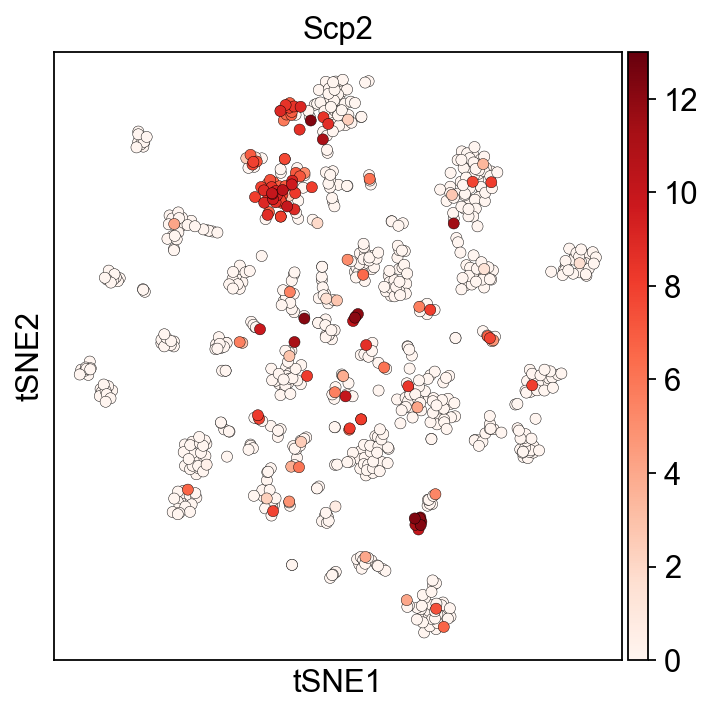

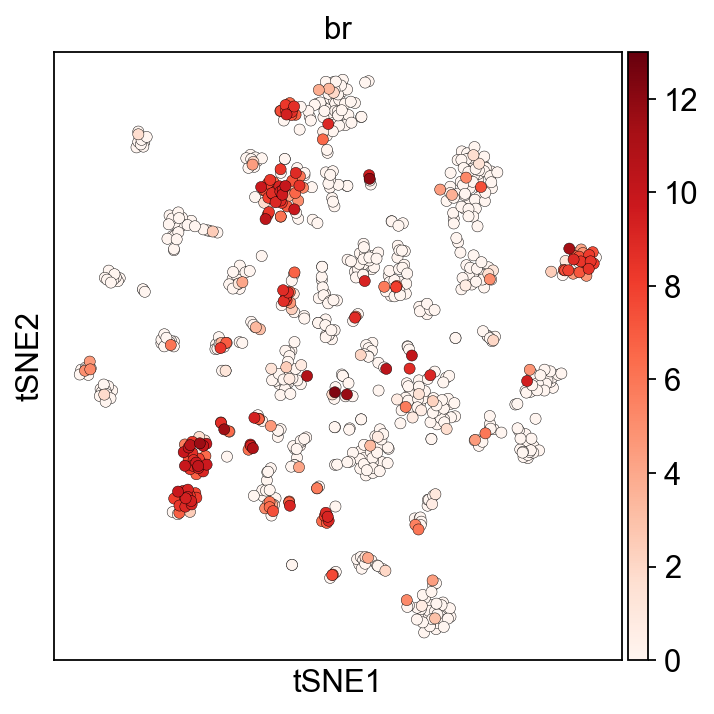

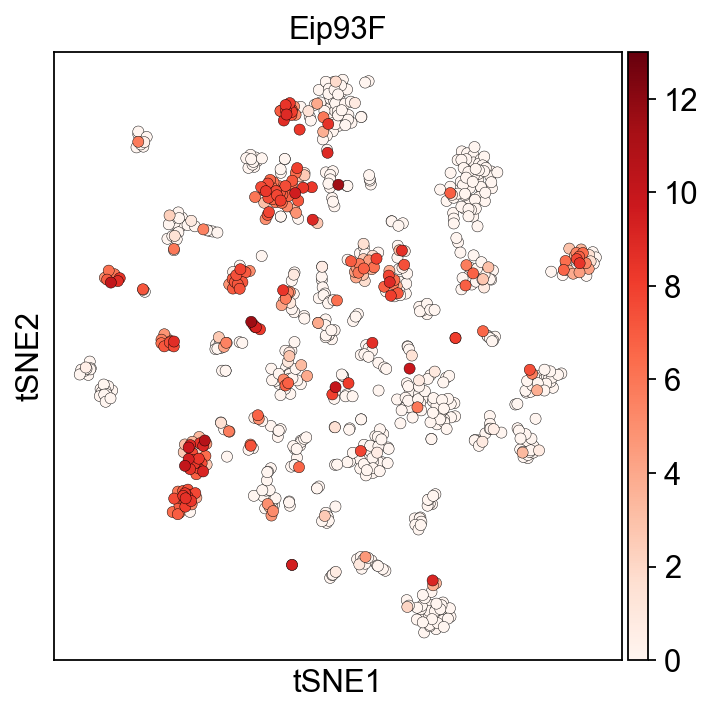

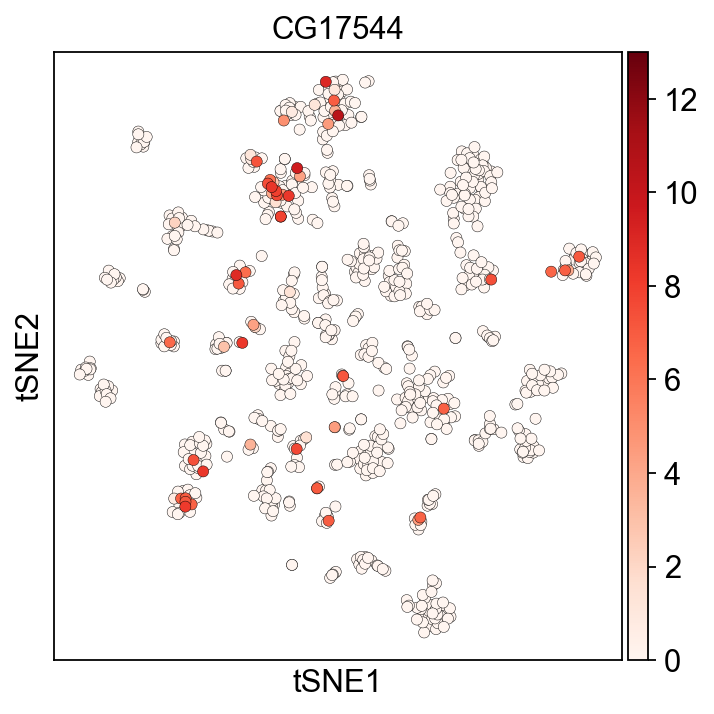

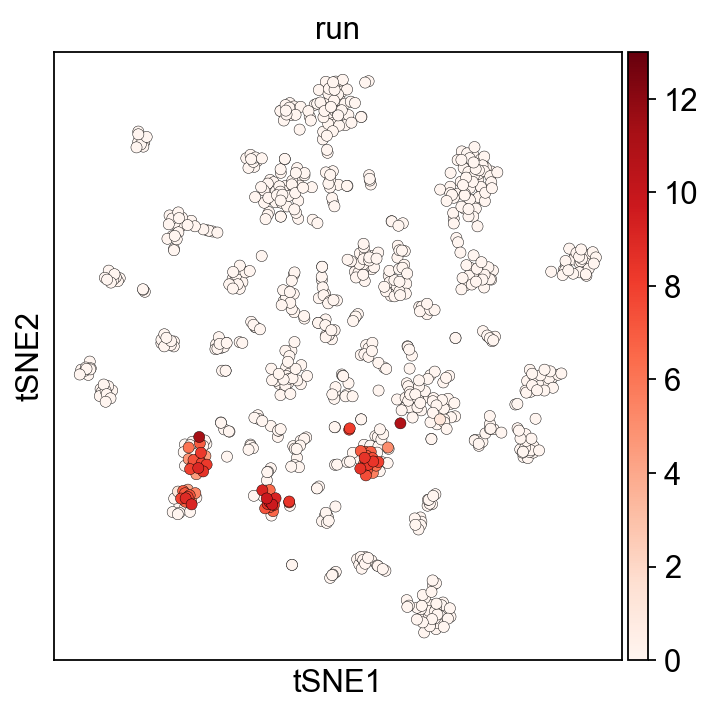

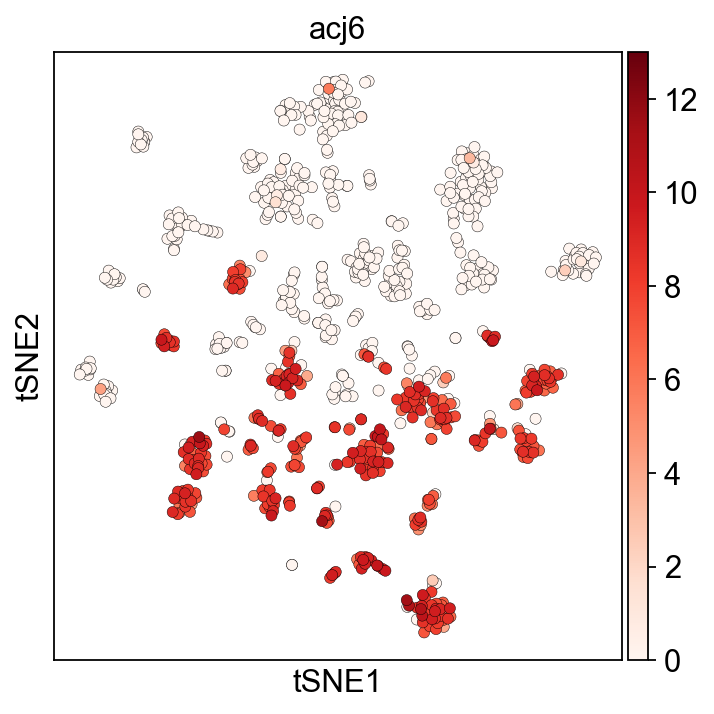

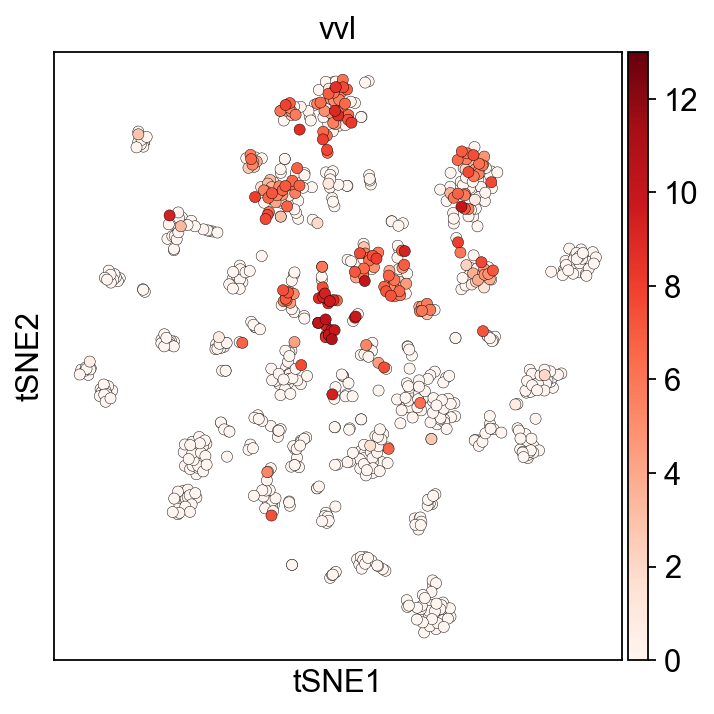

In [198]:
# myGenes =['mirr', 'ara', 'CG9650','CG17839','DIP-theta','MESR3','run']
# myGenes =['tsh', 'trol', 'C15','Lim1','trol','CG8861','CG1402','CG9896','CG1688','caup','danr']
# myGenes = ['toy','Gad1']
myGenes =['kn','unpg','CG31676','MsR1','Scp2','br','Eip93F','CG17544','run','acj6', 'vvl']

for gene in myGenes:
    sc.pl.tsne(adata_all, color=gene, size=(100,100), edgecolor="k", linewidths=0.2, vmax=13,
               color_map="Reds", save= '_'+gene+'.pdf')